In [1]:
%pip install numpy scipy matplotlib oasis-deconv

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
from scipy.signal import convolve, windows
import matplotlib.pyplot as plt
from oasis.functions import deconvolve, gen_data
from scipy.signal import find_peaks

c:\Users\delgr\Projects\intro-to-calcium-imaging-analysis-in-python-2025\.pixi\envs\default\Lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
y1, c1, s1 = map(np.squeeze, gen_data(N=1, seed=5, sn=0.1, framerate=10))
y2, c2, s2 = map(np.squeeze, gen_data(N=1, seed=5, sn=0.1, framerate=20))
y3, c3, s3 = map(np.squeeze, gen_data(N=1, seed=5, sn=0.1, framerate=30))

# Spike Inference From Calcium Traces

To extract spikes from calcium traces, it is essential to understand how calcium signals are generated from neural activity. Neurons fire rapidly, but calcium signals reflect this activity as slower, smoother traces. Convolution describes how spikes are transformed into calcium signals. To recover the original spikes, we use methods like OASIS to deconvolve the calcium traces. The output is continuous, so we apply thresholding to identify discrete spike events. Finally, these spike events are timestamped for further analysis and comparison.

---

## How would a spike train appear as a calcium trace? (Convolution)

In this section, we will see how calcium signals are produced from spikes using a process called convolution. When a neuron fires, it does not just cause a sharp, brief change in the signal. Instead, it produces a smooth, slowly fading signal that we observe in calcium imaging. We simulate this by convolving a spike train with a calcium kernel which a shape that describes how the signal should look after a single spike. This helps us understand how fast spiking activity is transformed into the slower calcium traces we record.

| **Code**                                         | **Description**                                                                                    |
| :----------------------------------------------- | :------------------------------------------------------------------------------------------------- |
| `windows.boxcar(win_len)`                        | Create a **boxcar kernel** of specified length (`win_len`).                                        |
| `windows.triang(win_len)`                        | Create a **triangle kernel** of specified length (`win_len`).                                      |
| `np.exp(-t / tau)`                               | Create an **exponential decay kernel** with decay constant `tau`.                                  |
| `np.exp(-t / tau_decay) - np.exp(-t / tau_rise)` | Create a **double exponential decay kernel** with rise (`tau_rise`) and decay (`tau_decay`) times. |
| `kernel_unnorm / kernel_unnorm.sum()`            | Normalize the kernel by dividing by the sum of its elements.                                       |
| `convolve(s1, kernel, mode='full')`              | **Convolve** the spike train (`s1`) with the kernel, generating a calcium trace.                   |
| `plt.plot(kernel)`                                     | Plot the kernel.   |



*How will my spikes look if they are convolved with a prebuilt kernel?*

**Example** How will my spikes look if they were convolved with a boxcar kernel of window size 3?

(0.0, 100.0)

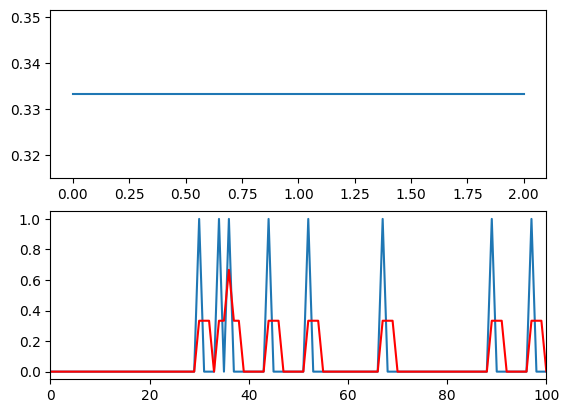

In [12]:
win_len = 3
kernel_unnorm = windows.boxcar(win_len)
kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(s1, kernel, mode='full')

plt.subplot(211)
plt.plot(kernel)

plt.subplot(212)
plt.plot(s1)
plt.plot(convolved_trace[:-win_len+1], color='r')
plt.xlim(0, 100)

How will my spikes look if they were convolved with a triangle kernel of window size 3?

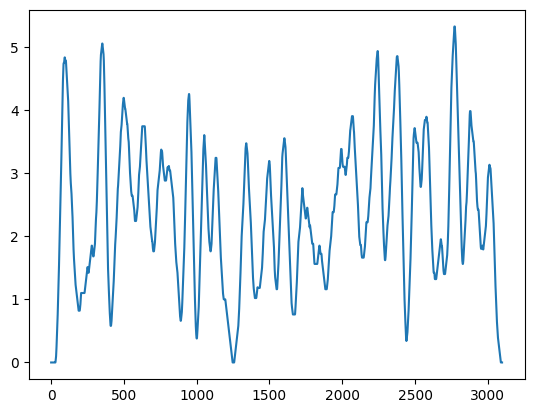

In [33]:
kernel = windows.triang(100)
kernel
data = convolve(kernel, s1, mode='full')
plt.plot(data)

How will my spikes look if they were convolved with a triangle kernel of window size 4?

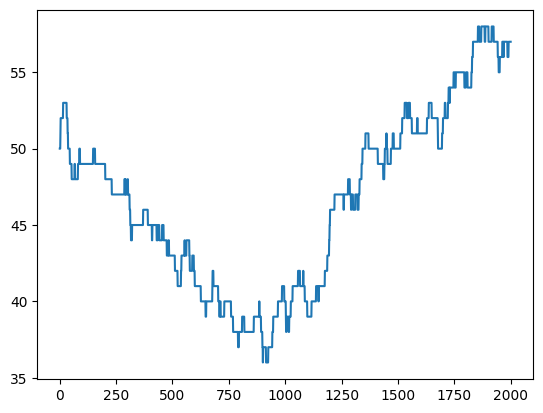

In [41]:
kernel = windows.boxcar(1000)
kernel
data = convolve(kernel, s1, mode='valid')
plt.plot(data)

*How will my spikes look if they are convolved with an exponential decay kernel?*

**Example** How will my spikes look when convolved with an exponential decay kernel with tau of 10 and window size of 101 frames?

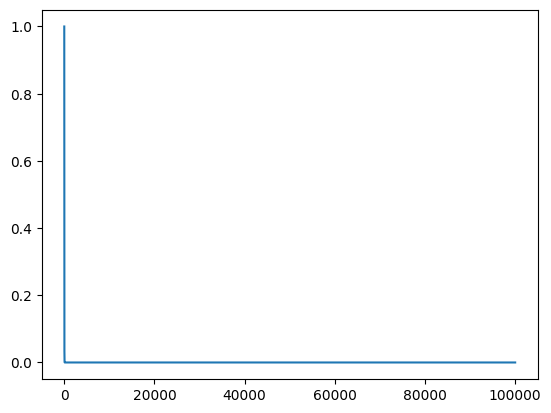

In [59]:
tau = 10
win_len = 100000
t = np.arange(win_len)
kernel_unnorm = np.exp(-t / tau)


plt.plot(kernel_unnorm);

(0.0, 100.0)

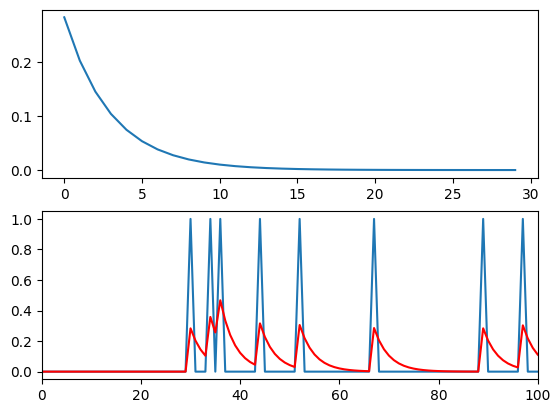

In [63]:
tau = 3
win_len = 30
t = np.arange(win_len)
kernel_unnorm = np.exp(-t / tau)


# plt.plot(kernel_unnorm);

kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(s1, kernel, mode='full')

plt.subplot(211)
plt.plot(kernel)

plt.subplot(212)
plt.plot(s1)
plt.plot(convolved_trace[:-win_len+1], color='r')
plt.xlim(0, 100)

How will my spikes look when convolved with an exponential decay kernel with tau of 1 frames and window size of 101 frames?

How will my spikes look when convolved with an exponential decay kernel with tau of 200 frames and window size of 101 frames?

*How will my spikes look if they are convolved with a double exponential decay kernel?*

**Example** How will my spikes look when convolved with a double exponential decay kernel with tau rise of 0.1 frame, tau_decay of 1.5 frames, and window size of 101 frames?

In [ ]:
tau_rise = 0.1
tau_decay = 1.5
win_len = 101
t = np.arange(win_len)
kernel_unnorm = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)
kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(s1, kernel, mode='full')

plt.subplot(211)
plt.plot(kernel)

plt.subplot(212)
plt.plot(s1)
plt.plot(convolved_trace[:-win_len+1], color='r')
plt.xlim(0, 100)

How will my spikes look when convolved with a double exponential decay kernel with tau rise of 29.9 frame, tau_decay of 30.0 frames, and window size of 101 frames?

How will my spikes look when convolved with a double exponential decay kernel with tau rise of 0.1 frame, tau_decay of 4.0 frames, and window size of 101 frames?

## OASIS

Now that we know how spikes generate calcium signals using a kernel, we want to do the reverse: go from calcium traces back to the original spikes. This is done through deconvolution. OASIS is a commonly used algorithm that estimates spike timings by finding a sparse set of events that, when convolved with a known calcium kernel, best matches the observed signal. The output is a continuous signal where higher values suggest stronger or more likely spike events.

| **Code**                        | **Description**                                                                                                 |
| :------------------------------ | :-------------------------------------------------------------------------------------------------------------- |
| `plt.subplot(211)`              | Set up the first subplot for plotting.                                                                          |
| `plt.subplot(212)`              | Set up the second subplot for plotting.                                                                         |
| `deconvolve(y)`                 | Apply the **deconvolution** function to the calcium trace `y` to infer spikes and baseline.                     |
| `plt.axhline(baseline)`         | Plot a horizontal line at the estimated **baseline** value.                                                     |
| `deconvolve(y, g=(0.9,))`       | Apply **deconvolution** to the calcium trace `y` with the parameter `g=(0.9,)` to modify spike inference.       |
| `deconvolve(y, g=(1.8, -0.81))` | Apply **deconvolution** to the calcium trace `y` with the parameter `g=(1.8, -0.81)` to modify spike inference. |


*I have calcium trace from a neuron. How can I infer spikes from it?*

**Example** Estimate spikes from calcium trace `y1`.

c:\Users\delgr\Projects\intro-to-calcium-imaging-analysis-in-python-2025\.pixi\envs\default\Lib\site-packages\oasis\functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[np.arange(lags)],


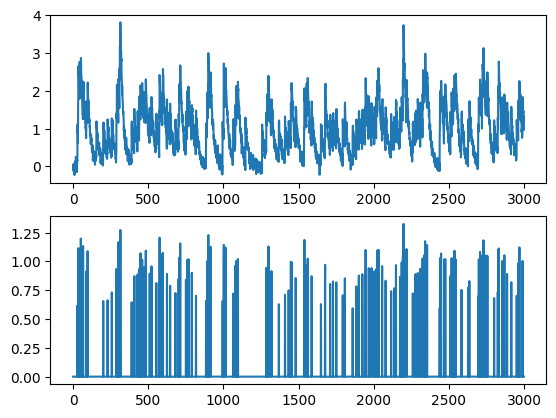

In [64]:
inferred_trace, estimated_spikes, estimated_baseline, g, _ = deconvolve(y1)

plt.subplot(211)
plt.plot(y1)

plt.subplot(212)
plt.plot(estimated_spikes)

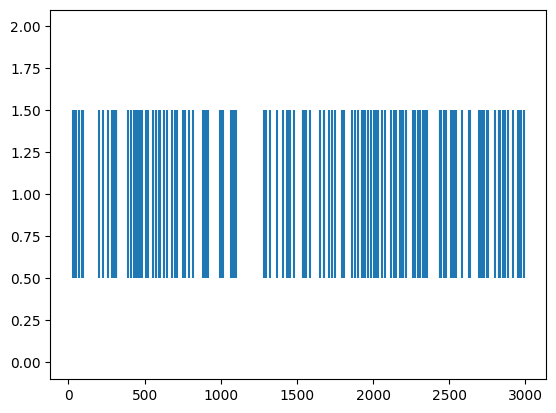

In [70]:
plt.eventplot(np.where(estimated_spikes > .25)[0]);

Estimate spikes from calcium trace `y2` and also plot the estimated baseline.

Estimate spikes from calcium trace `y3` and also add estimated baseline.

In [84]:
g

0.9326918820166279

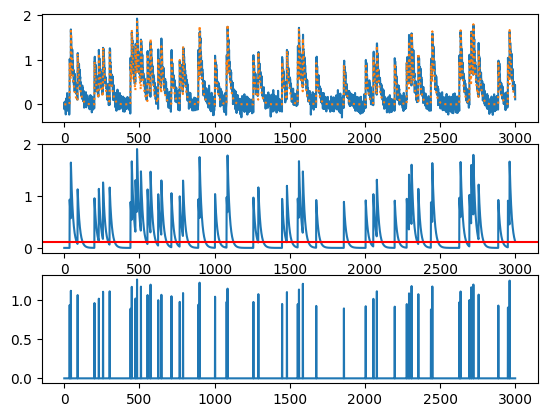

In [83]:
inferred_trace, estimated_spikes, estimated_baseline, g, _ = deconvolve(y3)

plt.subplot(311)
plt.plot(y3)
plt.plot(inferred_trace, ':')

plt.subplot(312)
plt.plot(inferred_trace)
plt.axhline(estimated_baseline, color='red')

plt.subplot(313)
plt.plot(estimated_spikes);

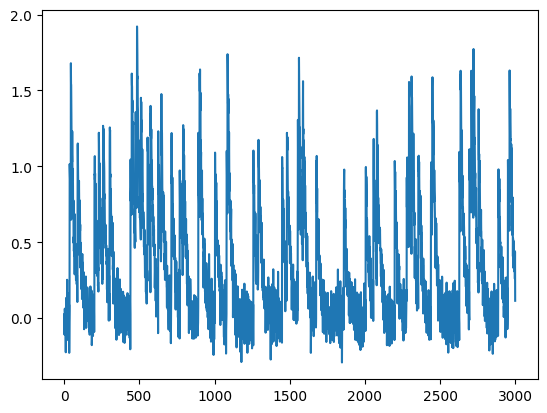

In [72]:
plt.plot(y3);

*How can I control for fast and slow decay of calcium transients?*

**Example** Give g1 co-efficient as 0.9.

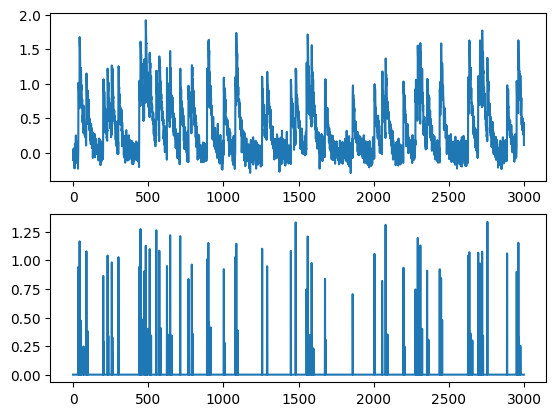

In [85]:
inferred_trace, estimated_spikes, estimated_baseline, g, _ = deconvolve(y3, g=(0.9,))

plt.subplot(211)
plt.plot(y3)

plt.subplot(212)
plt.plot(estimated_spikes)

Give g1 co-efficient as 0.1.

c:\Users\delgr\Projects\intro-to-calcium-imaging-analysis-in-python-2025\.pixi\envs\default\Lib\site-packages\oasis\functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[np.arange(lags)],


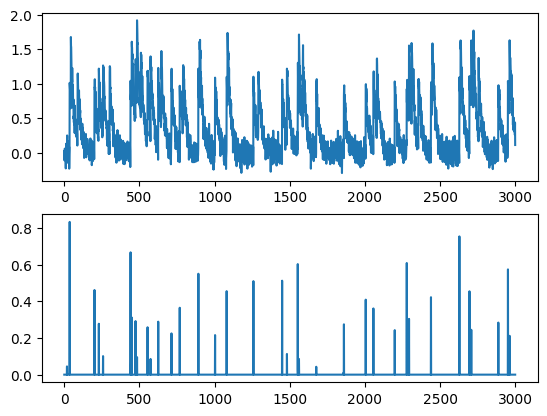

In [89]:
inferred_trace, estimated_spikes, estimated_baseline, g, _ = deconvolve(y3, g=(.99,))

plt.subplot(211)
plt.plot(y3)

plt.subplot(212)
plt.plot(estimated_spikes)

Give g1 co-efficient as 0.99.

Give g1 co-efficient as 0.9 and g2 as -0.81.

In [97]:
inferred_trace, estimated_spikes, estimated_baseline, g, _ = deconvolve(y3, g=(.9, .2))

plt.subplot(211)
plt.plot(y3)

plt.subplot(212)
plt.plot(estimated_spikes)

c:\Users\delgr\Projects\intro-to-calcium-imaging-analysis-in-python-2025\.pixi\envs\default\Lib\site-packages\oasis\functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[np.arange(lags)],


ValueError: math domain error

*How can I compare the trace inferred from the spikes with my real calcium signal?*

**Example** Compare the inferred calcium traces with real calcium trace of y1.

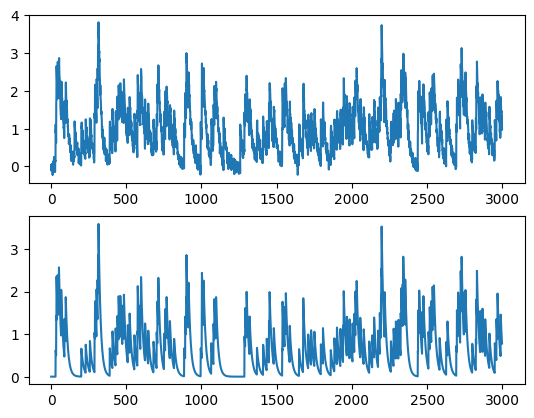

In [93]:
inferred_trace, estimated_spikes, estimated_baseline, g, _ = deconvolve(y1)

plt.subplot(211)
plt.plot(y1)

plt.subplot(212)
plt.plot(inferred_trace)

Compare the inferred calcium traces with real calcium trace of y2 with g1 as 0.9.

In [128]:
%pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from tqdm import tqdm


gs, errors = [], []
for g in tqdm(np.arange(.1, .999, .002)):
    inferred_trace, estimated_spikes, estimated_baseline, g, _ = deconvolve(y1, g=(g,))
    error = np.sqrt(np.mean(np.square(inferred_trace - y1)))
    gs.append(g)
    errors.append(error)



plt.plot(gs, errors);
plt.xlabel('g')
plt.title('RMS Error: Fluorescence Trace vs OASIS Inferred')
plt.title('RMS Error');


100%|██████████| 450/450 [00:43<00:00, 10.32it/s]


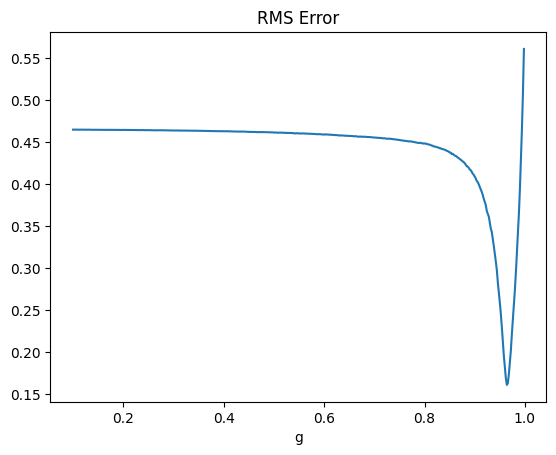

In [14]:
plt.plot(gs, errors);
plt.xlabel('g')
plt.title('RMS Error: Fluorescence Trace vs OASIS Inferred')
plt.title('RMS Error');

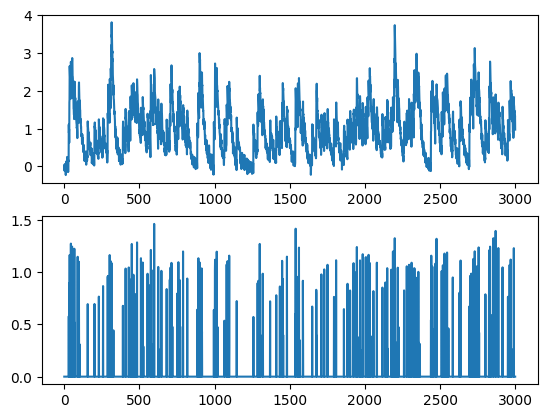

In [102]:
inferred_trace, estimated_spikes, estimated_baseline, g, _ = deconvolve(y1, g=(.9,))

plt.subplot(211)
plt.plot(y1)

plt.subplot(212)
plt.plot(estimated_spikes)

In [109]:
deconvolve?

Signature:
deconvolve(
    y,
    g=(None,),
    sn=None,
    b=None,
    b_nonneg=True,
    optimize_g=0,
    penalty=0,
    **kwargs,
)
Docstring:
Infer the most likely discretized spike train underlying an fluorescence trace

Solves the noise constrained sparse non-negative deconvolution problem
min |s|_q subject to |c-y|^2 = sn^2 T and s = Gc >= 0
where q is either 1 or 0, rendering the problem convex or non-convex.

Parameters:
-----------
y : array, shape (T,)
    Fluorescence trace.
g : tuple of float, optional, default (None,)
    Parameters of the autoregressive model, cardinality equivalent to p.
    Estimated from the autocovariance of the data if no value is given.
sn : float, optional, default None
    Standard deviation of the noise distribution.  If no value is given,
    then sn is estimated from the data based on power spectral density if not provided.
b : float, optional, default None
    Fluorescence baseline value. If no value is given, then b is optimized.
b_nonneg

In [124]:
np.mean((inferred_trace - y1) ** 2)

np.float64(0.43035933812064575)

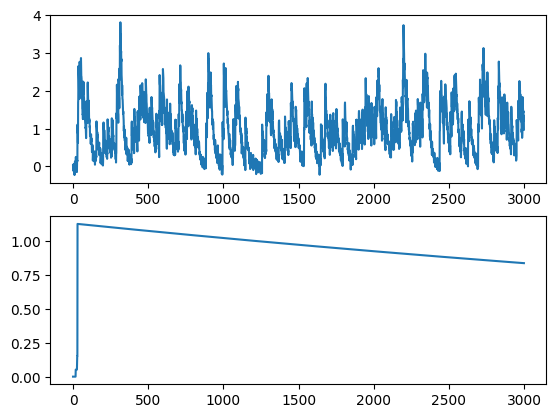

In [123]:
inferred_trace, estimated_spikes, estimated_baseline, g, _ = deconvolve(y1, g=(.9999,))

plt.subplot(211)
plt.plot(y1)

plt.subplot(212)
plt.plot(inferred_trace)

Compare the inferred calcium traces with real calcium trace of y1 with g1 as 1.8 and g2 as -0.81.

## Thresholding and Spike times

The output from OASIS is continuous, showing how likely or strong each spike might be. But for many kinds of analysis, we need clear events where either a spike happened, or it did not. To do this, we apply a threshold to the OASIS output. Any value above the threshold is considered a spike.

| **Code**                                     | **Description**                                                |
| :------------------------------------------- | :------------------------------------------------------------- |
| `np.max(spikes)`                             | Get the **maximum** spike value.                               |
| `np.percentile(spikes, 95)`                  | Find the **95th percentile** of spikes.                        |
| `np.mean(spikes)`                            | Calculate the **mean** of spikes.                              |
| `np.std(spikes)`                             | Compute the **standard deviation** of spikes.                  |
| `fr = 10`                                    | Set **sampling frequency** to 10 Hz.                           |
| `spk_inds = np.where(spikes > threshold)[0]` | Identify **spike indices** above threshold.                    |
| `spk_times = spk_inds / fr`                  | Convert **spike indices** to **times**.                        |
| `plt.eventplot(spk_times)`                   | Plot **spike times** as events.                                |
| `find_peaks(spikes, height=0.5, distance=5)` | **Detect peaks** in spikes with height > 0.5 and distance > 5. |

In [ ]:
_, inferred_spikes1, _, _, _ = deconvolve(y1)
_, inferred_spikes2, _, _, _ = deconvolve(y2)
_, inferred_spikes3, _, _, _ = deconvolve(y3)

*How do I get spike times by fixing an amplitude manually?*

**Example** For y1, find spike times of all spikes with amplitude larger than 1.0.

In [ ]:
threshold = 1.0
fr = 10
spk_inds = np.where(inferred_spikes1 > threshold)[0]
spk_times = spk_inds / fr
plt.eventplot(spk_times)

For y1, find spike times of all spikes with amplitude larger than 0.01.

For y1, find spike times of all spikes with amplitude larger than 0.5.

*How can I fix the amplitude threshold automatically?*

**Example** For y1, set threshold to be higher than 10% of maximum amplitude.

In [ ]:
threshold = 0.1 * np.max(inferred_spikes1)
fr = 10
spk_inds = np.where(inferred_spikes1 > threshold)[0]
spk_times = spk_inds / fr
plt.eventplot(spk_times)

For y1, set threshold to be higher than 95th-percentile of the amplitudes.

For y1, set threshold to be higher than three-sigma.

*How can I prevent multiple spike detections from a single calcium event?*

**Example** For y1, only get spike times for spikes with amplitudes larger than 0.5 with minimum distance of at least 5 frames.

In [ ]:
spk_inds, properties = find_peaks(inferred_spikes1, height=0.5, distance=5)
fr = 10
spk_times = spk_inds / fr
plt.eventplot(spk_times)

For y1, only get spike times for spikes with amplitudes larger than 0.5 with minimum distance of at least 100 frames.

For y1, only get spike times for spikes with amplitudes larger than 0.5 with minimum distance of at least 10 frames.

## Saving Timestamped Data

Once we have identified when spikes likely occurred by thresholding, we save the corresponding time points. These timestamped events are useful for further analysis, such as comparing activity across cells, aligning activity to behavioral events, or building summary statistics. In this section, we will save these spike times as an array of indices or timestamps.

| **Code**                                                  | **Description**                                               |
| :-------------------------------------------------------- | :------------------------------------------------------------ |
| `np.save('spks1.npy', spk_times1)`                        | Save **spike times** for neuron 1 to a `.npy` file.           |
| `spk1 = np.load('spks1.npy')`                             | Load **spike times** for neuron 1 from a `.npy` file.         |
| `plt.eventplot(spk2)`                                     | Plot **spike times** for neuron 2 as an event plot.           |
| `spks = np.array([spk_times1, spk_times2], dtype=object)` | Create an array of **spike times** for multiple neurons.      |
| `spks = np.load('spks_1_2.npy', allow_pickle=True)`       | Load **spike times** for multiple neurons from a `.npy` file. |
| `plt.eventplot(spks[1])`                                  | Plot **spike times** for neuron 2 from the loaded data.       |

In [ ]:
threshold = np.percentile(inferred_spikes1, 95)
fr = 10
spk_inds = np.where(inferred_spikes1 > threshold)[0]
spk_times1 = spk_inds / fr

In [ ]:
threshold = np.percentile(inferred_spikes2, 95)
fr = 20
spk_inds = np.where(inferred_spikes2 > threshold)[0]
spk_times2 = spk_inds / fr

In [ ]:
threshold = np.percentile(inferred_spikes3, 95)
fr = 30
spk_inds = np.where(inferred_spikes3 > threshold)[0]
spk_times3 = spk_inds / fr

*How do I save spike times of a single neuron?*

**Example** Save `spk_times1` as `spk1.npy`.

In [ ]:
np.save('spk1.npy', spk_times1)

Save `spk_times2` as `spk2.npy`.

Save `spk_times3` as `spk3.npy`.

*How do I load spike times of a single neuron?*

*Example* Load `spk1.npy`.

In [ ]:
spk1 = np.load('spk1.npy')
plt.eventplot(spk1)

Load `spk2.npy`.

Load `spk3.npy`.

*How do I save spike times of multiple neurons?*

**Example** Save `spk_times1` and `spk_times1` together as `spk_1_2.npy`.

In [ ]:
spks = np.array([spk_times1, spk_times2], dtype=object)
np.save('spk_1_2.npy', spks)

Save `spk_times2` and `spk_times3` together as `spk_2_3.npy`.

Save `spk_times1`, `spk_times2`, and `spk_times3` together as `spk_1_2_3.npy`.

*How do I load spike times of multiple neurons?*

**Example** Load `spk_1_2.npy` and plot the events from first neuron.

In [ ]:
spks = np.load('spk_1_2.npy', allow_pickle=True)
plt.eventplot(spks[0])

Load `spk_1_2.npy` and plot the events from second neuron.

Load `spk.npy` and plot the events from the last neuron.